### Setup Spark environment

In [ ]:
import findspark
findspark.init()

import pyspark
from pyspark import SparkContext, SparkConf
sc = SparkContext()

### Partitioning

In [198]:
import datetime

class Partition(object):
    def __init__(self, data, partition_num, eps, method):

        self.partition_num = partition_num
        self.eps = eps
        self.ROUND_DIGIT = 6

        if method not in ('spatial split'):
            print('Error: Unknown method', method)
            exit(-1)

        self.method = method

    def create_partitions_with_spark(self, data, border_coordinates):
        allow_overlapping_boxes = True

        partition_num = len(border_coordinates)
        rdd = data

        def label_partition(element):
            new_elements = []
            for k in range(partition_num):
                    box = border_coordinates[k]
                    x = element[0]
                    y = element[1]
                    if x < box[2] and x >= box[0] and y < box[3] and y >= box[1]:
                            new_elements.append((element, k))
                            if not allow_overlapping_boxes:
                                break

            return new_elements

        partitioned_rdd = rdd.map(label_partition).flatMap(lambda x: x).map(lambda x: (
                str(x[1]), x[0])).partitionBy(partition_num, lambda k: int(k[0])).map(lambda x: x[1])
        # partitioned_rdd.glom().collect()

        return partitioned_rdd

    def split(self, data):

        if data.count() <= 0:
            # nothing to do
            return data, []

        if self.method == 'spatial split':
            # get the factor list of the partition num to separate the space for x and y more evenly
            factors = []
            for factor in range(1, self.partition_num+1):
                if self.partition_num % factor == 0:
                    # if divisible, it is a factor
                    # if the factor^2 = partition_num, we should append twice
                    if factor * factor == self.partition_num:
                        factors.append(factor)
                    factors.append(factor)

            # default 1 x partition_num
            x_partition_num = factors[len(factors) // 2-1]
            y_partition_num = factors[len(factors) // 2]

            # error checking
            if x_partition_num * y_partition_num != self.partition_num:
                print('Error: Incorrect x y partition',
                            x_partition_num, y_partition_num)
                exit(-1)

            # store the partitioned x y left-down coordinates to set up the border
            x_coordinates = []
            y_coordinates = []

            # find the range
            minX = data.min()[0]
            maxX = data.max()[0]
            minY = data.min(lambda x: x[1])[1]
            maxY = data.max(lambda x: x[1])[1]

            # split the x range by x_partition_num and that of y
            for i in range(x_partition_num):
                interval = round((maxX - minX) / x_partition_num)
                x_coordinates.append(minX + i * interval)

            for i in range(y_partition_num):
                interval = round((maxY - minY) / y_partition_num)
                y_coordinates.append(minY + i * interval)

            # Partition ID
            #  2 5 8 ...
            #  1 4 7 ...
            #  0 3 6 ...

            # output the border coordinates
            border_coordinates = []
            for i in range(len(x_coordinates)):
                for j in range(len(y_coordinates)):
                    # next x y is the next item in coordinate list
                    # if already the last item, the next item will be the right data boundary (maxX or maxY)
                    # +0.01 here is to make sure no data touch the top/right boundary for easy partition logic
                    next_x = round(
                            maxX+0.01, self.ROUND_DIGIT) if i == len(x_coordinates)-1 else x_coordinates[i+1]
                    next_y = round(
                            maxY+0.01, self.ROUND_DIGIT) if j == len(y_coordinates)-1 else y_coordinates[j+1]
                    border_coordinates.append(
                            (x_coordinates[i], y_coordinates[j], next_x, next_y))

            partitioned_data = self.create_partitions_with_spark(
                    data, border_coordinates)

        # border_coordinates
        # [(0.8, 0.8, 100.0, 50.8), (0.8, 50.8, 100.0, 100.0)]

        return partitioned_data, border_coordinates

    def expand(self, data, border_coordinates):
        # expand each partition by eps
        new_border_coordinates = []
        for i in range(len(border_coordinates)):
            new_border_coordinate = []
            border_coordinate = list(border_coordinates[i])

            new_border_coordinate.append(
                    round(border_coordinate[0] - self.eps, self.ROUND_DIGIT))
            new_border_coordinate.append(
                    round(border_coordinate[1] - self.eps, self.ROUND_DIGIT))
            new_border_coordinate.append(
                    round(border_coordinate[2] + self.eps, self.ROUND_DIGIT))
            new_border_coordinate.append(
                    round(border_coordinate[3] + self.eps, self.ROUND_DIGIT))
            new_border_coordinates.append(tuple(new_border_coordinate))

            partitioned_data = self.create_partitions_with_spark(
                    data, new_border_coordinates)
        return partitioned_data, new_border_coordinates


# Do the partition
if __name__ == '__main__':
    # x = [[1, 1.2, 0.8, 3.7, 3.9, 3.6,  10., 10.1,  1.2, 13.],
    #  [  1.1, 0.8, 1, 4, 3.9, 4.1, 10, 10.1,  10.2, 1. ]]

    lines = sc.textFile('./3000.txt')
    x = lines.map(lambda x: x.split()).map(lambda x: (int(x[0]), int(x[1])))

    PARTITION = 2
    EPS = 1000
    start_time = datetime.datetime.now().timestamp()
    
    par_obj = Partition(x, PARTITION, EPS, 'spatial split')
    old_result, old_borders = par_obj.split(x)
    result, borders = par_obj.expand(x, old_borders)
    
    end_time = datetime.datetime.now().timestamp()
    
    print()
    print('==================Debug Ground==================')
    # Find the number of elements in each parttion

    def partitionsize(it):
        yield len(list(it))

    # sum to 3000
    print('Size of each partition:',
                old_result.mapPartitions(partitionsize).collect())
    # print('Result', result.glom().collect())
    print('Border', old_borders)
    print()
    
    print('After expand bounding box')
    print('Size of each partition:', result.mapPartitions(partitionsize).collect())
    print('Border', borders)
    print()
    print('Time:', end_time - start_time)


==================Debug Ground==================
Size of each partition: [1238, 1762]
Border [(0, 32064, 65535.01, 48521), (0, 48521, 65535.01, 64978.01)]

After expand bounding box
Size of each partition: [1330, 1875]
Border [(-1000, 31064, 66535.01, 49521), (-1000, 47521, 66535.01, 65978.01)]

Time: 5.235932111740112


### Pass Partition data to DBSCAN 

In [199]:
import math
def distFunc(a,b):
    return math.sqrt((b[0] - a[0])**2 + (b[1] - a[1])**2)

def getNeighbours(labelled_map, distFunc, p, EPS):
    neighbours = []
    for q in labelled_map: 
        if distFunc(p,q) <= EPS:
            neighbours.append(q)
    return neighbours 

def dbscan(index, partition_list):
    C = 0 
    labelled_map = {}
    labelled_list = []
    for p in partition_list:
        labelled_map[p] = 0
    
    for p in labelled_map:
        if labelled_map[p] != 0:
            continue 

        N = getNeighbours(labelled_map, distFunc, p, EPS)
        # N is a list containing the neighbour points ((x,y),label)
        if len(N) < minPts:
            labelled_map[p] = -1
            continue
        C += 1
        labelled_map[p] = C
        
        for q in N:
            if labelled_map[q] == -1:
                labelled_map[q] = C
            if labelled_map[q] != 0:
                continue
            labelled_map[q] = C
            N_1 = getNeighbours(labelled_map, distFunc, q, EPS)
            if len(N_1) >= minPts:
                for pt in N_1:
                    if pt not in N:
                        N.append(pt)
                        
    for p in labelled_map:
        labelled_list.append((p,labelled_map[p]))
    return (labelled_list)

minPts = 10
EPS = 1000

print('Size of Partitions Before DBSCAN:', result.mapPartitions(partitionsize).collect())

start_time = datetime.datetime.now().timestamp()

# do DBSCAN for each partition 
labelled_RDD = result.mapPartitionsWithIndex(dbscan)
end_time = datetime.datetime.now().timestamp()

print('Size of Partitions After DBSCAN:', labelled_RDD.mapPartitions(partitionsize).collect())

print('Time:', end_time - start_time)
labelled_list = labelled_RDD.collect()

Size of Partitions Before DBSCAN: [1330, 1875]
Size of Partitions After DBSCAN: [1330, 1875]
Time: 0.0009970664978027344


In [201]:
labelled_list[1:10]

[((52694, 42750), 1),
 ((53253, 43024), 1),
 ((54925, 42624), 1),
 ((54973, 43980), 1),
 ((52967, 42955), 1),
 ((55143, 40238), 1),
 ((53071, 44896), 1),
 ((55710, 44219), 1),
 ((54459, 43964), 1)]

### Result Plotting

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

d:\python\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


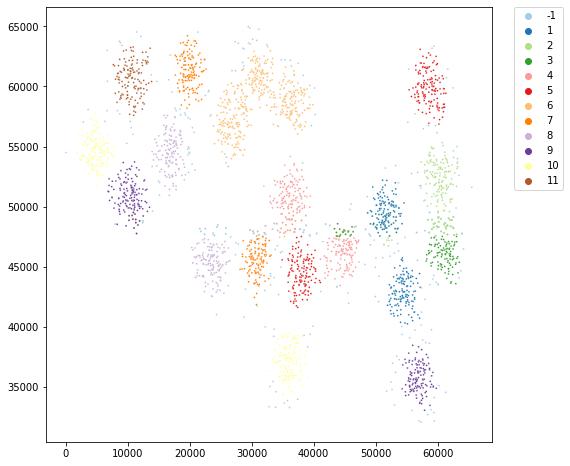

In [181]:
x = []
y = []
c = []
# plt.figure(figsize=(8, 8))
for i in labelled_list:
    x.append(i[0][0])
    y.append(i[0][1])
    c.append(i[1])
# plt.scatter(x,y, 1)
plt.figure(figsize=(8, 8))
sns.scatterplot(x,y, s=3, hue=c, palette='Paired')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

d:\python\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


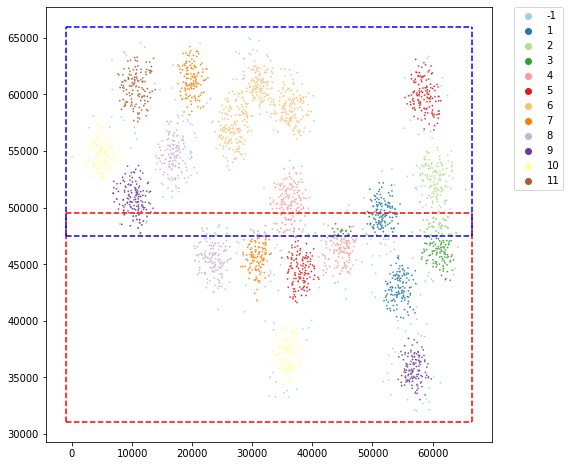

In [182]:
plt.figure(figsize=(8, 8))

sns.scatterplot(x,y, s=3, hue=c, palette='Paired')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
colors = ["r", "b", "g","cyan", "y", "c", "m", "pink","yellow", "brown"]


for i in range(len(borders)):
    plt.plot([borders[i][0],borders[i][2]],[borders[i][1], borders[i][1]], 'k--', color = colors[i])
    plt.plot([borders[i][2],borders[i][2]],[borders[i][1], borders[i][3]], 'k--', color = colors[i])    
    plt.plot([borders[i][0],borders[i][2]],[borders[i][3], borders[i][3]], 'k--', color = colors[i])    
    plt.plot([borders[i][0],borders[i][0]],[borders[i][1], borders[i][3]], 'k--', color = colors[i])
    

### DBSCAN logic

DBSCAN(DB, distFunc, eps, minPts) {
    C := 0                                                  /* Cluster counter */
    for each point P in database DB {
        if label(P) ≠ undefined then continue               /* Previously processed in inner loop */
        Neighbors N := RangeQuery(DB, distFunc, P, eps)     /* Find neighbors */
        if |N| < minPts then {                              /* Density check */
            label(P) := Noise                               /* Label as Noise */
            continue
        }
        C := C + 1                                          /* next cluster label */
        label(P) := C                                       /* Label initial point */
        SeedSet S := N \ {P}                                /* Neighbors to expand */
        for each point Q in S {                             /* Process every seed point Q */
            if label(Q) = Noise then label(Q) := C          /* Change Noise to border point */
            if label(Q) ≠ undefined then continue           /* Previously processed (e.g., border point) */
            label(Q) := C                                   /* Label neighbor */
            Neighbors N := RangeQuery(DB, distFunc, Q, eps) /* Find neighbors */
            if |N| ≥ minPts then {                          /* Density check (if Q is a core point) */
                S := S ∪ N                                  /* Add new neighbors to seed set */
            }
        }
    }
}

RangeQuery(DB, distFunc, Q, eps) {
    Neighbors N := empty list
    for each point P in database DB {                      /* Scan all points in the database */
        if distFunc(Q, P) ≤ eps then {                     /* Compute distance and check epsilon */
            N := N ∪ {P}                                   /* Add to result */
        }
    }
    return N
}